# Customer Churn Prediction

# Final EDA and Modeling

Covid-19 has brought challenges and complications to the telecommunications industry. Large corporations, small business and households depend on telecom companies to operate their daily tasks. According to [IEE Communication Society,](https://techblog.comsoc.org/2020/08/27/covid-19-challenges-faced-by-telcos-and-impact-on-the-telecom-sector/)"The unprecedented global health emergency is taxing networks and platforms to the limit, with some operators and platforms reporting demand spikes as high as 800%.”

In the face of the uncertain future, customers are trying to strike a balance between expanding to meet higher demand in the short-term and preserving cash to weather a protracted economic downturn. The [IFC, International Financial Corporation](https://www.ifc.org/wps/wcm/connect/1d490aec-4d57-4cbf-82b3-d6842eecd9b2/IFC-Covid19-Telecommunications_final_web_2.pdf?MOD=AJPERES&CVID=n9nxogP) studies found that lower-income customer groups, who are experiencing the most damage, are expected to reduce or stop purchasing airtime and data bundles. 

With this in mind, Data Science can help mitigate the worries of this Telecommunication Company by focusing on the customer churn. Customer churn occurs when your customer or subscriber stops using your product or service within a specific time period. By creating prediction models that can mitigate customer churn, the company can focus resources and funding into maintaining its infrastructure. Since IFC states: "Infrastructure operators such as tower companies and energy service companies (ESCOs) may see a drop in new contracts."

The model that was implemented to help with the customer churn rate was able to accurately predict a customer will churn 95% of the time. 


#### Loading Necessary Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from createdfunctions import remove_dups,reason_cleanup,to_binary,percentage_col,scoring,names
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

In [2]:
#loading dataframes
df1=pd.read_excel("EDA_&_Modeling/Telco_customer_churn.xlsx")
df2=pd.read_excel("EDA_&_Modeling/Telco_customer_churn_status.xlsx")
df3=pd.read_excel("EDA_&_Modeling/Telco_customer_churn_services.xlsx")
df4=pd.read_excel("EDA_&_Modeling/Telco_customer_churn_demographics.xlsx")

In [3]:
#Mergin dataframes into one
df1_2=pd.merge(df1, df2, left_on='CustomerID', right_on='Customer ID', how='left').drop('Customer ID', axis=1)
df3_4=pd.merge(df3, df4, left_on='Customer ID', right_on='Customer ID', how='left')
customer_df=pd.merge(df1_2, df3_4, left_on='CustomerID', right_on='Customer ID', how='left').drop('Customer ID', axis=1)

In [4]:
customer_df.head()

,CustomerID,Count_x_x,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender_x,Senior Citizen_x,Partner,Dependents_x,Tenure Months,Phone Service_x,Multiple Lines_x,Internet Service_x,Online Security_x,Online Backup_x,Device Protection,Tech Support,Streaming TV_x,Streaming Movies_x,Contract_x,Paperless Billing_x,Payment Method_x,Monthly Charges,Total Charges_x,Churn Label_x,Churn Value_x,Churn Score_x,CLTV_x,Churn Reason_x,Count_y_x,Quarter_x,Satisfaction Score,Customer Status,Churn Label_y,Churn Value_y,Churn Score_y,CLTV_y,Churn Category,Churn Reason_y,Count_x_y,Quarter_y,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service_y,Avg Monthly Long Distance Charges,Multiple Lines_y,Internet Service_y,Internet Type,Avg Monthly GB Download,Online Security_y,Online Backup_y,Device Protection Plan,Premium Tech Support,Streaming TV_y,Streaming Movies_y,Streaming Music,Unlimited Data,Contract_y,Paperless Billing_y,Payment Method_y,Monthly Charge,Total Charges_y,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Count_y_y,Gender_y,Age,Under 30,Senior Citizen_y,Married,Dependents_y,Number of Dependents
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer,1,Q3,1,Churned,Yes,1,86,3239,Competitor,Competitor made better offer,1,Q3,No,0,2,None,Yes,10.47,No,Yes,DSL,21,Yes,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,53.85,108.15,0.0,0,20.94,129.09,1,Male,37,No,No,No,No,0
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved,1,Q3,2,Churned,Yes,1,67,2701,Other,Moved,1,Q3,No,0,2,None,Yes,9.12,No,Yes,Fiber Optic,51,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,70.70,151.65,0.0,0,18.24,169.89,1,Female,19,Yes,No,No,Yes,2
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved,1,Q3,3,Churned,Yes,1,86,5372,Other,Moved,1,Q3,No,0,8,None,Yes,12.15,Yes,Yes,Cable,26,No,No,Yes,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,99.65,820.50,0.0,0,97.20,917.70,1,Female,31,No,No,No,Yes,2
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved,1,Q3,3,Churned,Yes,1,84,5003,Other,Moved,1,Q3,No,0,28,Offer C,Yes,4.89,Yes,Yes,Fiber Optic,47,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,104.80,3046.05,0.0,0,136.92,3182.97,1,Female,23,Yes,No,Yes,Yes,3
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices,1,Q3,1,Churned,Yes,1,89,5340,Competitor,Competitor had better devices,1,Q3,No,0,49,None,Yes,44.33,Yes,Yes,Fiber Optic,11,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,103.70,5036.30,0.0,0,2172.17,7208.47,1,Male,38,No,No,No,Yes,1


The data that was utilized is the Telco customer churn database from [IBM Business Analytics.](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)

The Telco customer churn data contains information about a fictional telcom company that provided home phone and Internet services to 7043 customers in California in Q3. It indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score, and Customer Lifetime Value (CLTV) index.

Some interesting features to note:
* *Churn Value*: Whether or not a person left the telecommunications company.
* *Age*: Age at the time of collecting the data.
* *Total Charge*: In dollars, the amount of money consumer paid to the company in the span of the time they were or still are in the company for online services.
* *Total Revenue*: In dollars, the amount of money consumer paid to the company in the span of the time they were or still are in the company for telephone services.
* *Churn Category*: A high-level category for the customer’s reason for churning: Attitude, Competitor, Dissatisfaction, Other, Price. When they leave the company, all customers are asked about their reasons for leaving. Directly related to Churn Reason.
* *Churn Reason*: A customer’s specific reason for leaving the company. Directly related to Churn Category.
* *Tenure Months*: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.
* *Customer Status*: Indicates the status of the customer at the end of the quarter: Churned, Stayed, or Joined

## EDA

In [5]:
#Cleaning up duplicates 
customer_df=customer_df.T.drop_duplicates().T
customer_df.columns=[column.lower().strip("_x").strip("_y").replace(" ","_")for column in customer_df.columns] 

In [6]:
#Removing duplicates that were not caught by the previous function.
remove_dup=["internet_service","online_securit","online_backup","multiple_lines","streaming_tv","payment_method","total_charges","contract","streaming_movies","churn_reason"]
remove_dups(remove_dup,customer_df)

In [7]:
#Dropping Redundant columns
customer_df.drop(["lat_long","customerid","churn_label","count","countr","state","quarter",],axis=1,inplace=True)

Fist I started by looking at my target variable. I wanted to see what was the amount of customers that have churned and those who have not, or people who left the company and those who stayed. I wanted to see what was the difference in percentage of each category to get a sense of how large is the percentage of customer loss for this company.

Text(0.5, 0, 'Churned')

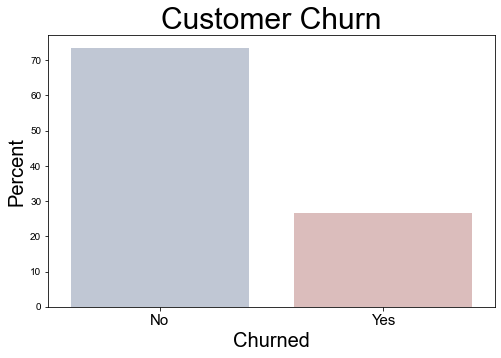

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
churn=pd.DataFrame(customer_df["churn_value"].value_counts(normalize=True))
churn["churn_value"]=percentage_col(churn,"churn_value")
ax=sns.barplot(x=churn.index,y=churn.churn_value,palette="vlag",ci=None)
sns.set('talk')
ax.set_xticklabels(["No","Yes"],rotation=0,fontsize=15)
ax.set_title("Customer Churn",fontsize=30)
ax.set_ylabel("Percent",fontsize=20)
ax.set_xlabel("Churned",fontsize=20)

The results show that currently the amount of customers that have left this company are around 30%. According to [Survicate.com](https://survicate.com/customer-satisfaction/customer-churn/) the average churn rate for American Telecommunications companies is 0.83%. This means that our churn rate is quite high. Although we do have to take into account that this is a small sample and may not portray the full extent of the customer base.

Next, I wanted to look at the types of Contracts the company offers and compare that to the churn of each group. This graph shows the percent distribution of customers that churned and not the percentage of each category's churn.

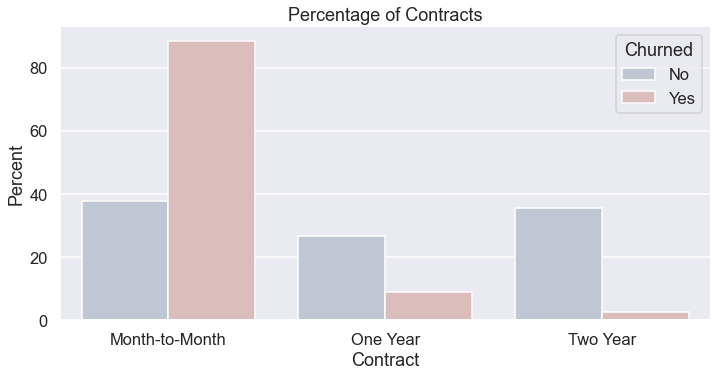

In [9]:
cont=pd.melt(customer_df[["tel_contract","churn_value","zip_code"]].groupby(["tel_contract","churn_value"]).count().T)
cont.value=percentage_col(cont,"value",string=True,churn=True)
cont=cont.rename(columns={'churn_value': 'Churned'})
sns.set('talk')
ax=sns.catplot(x='tel_contract', y='value',aspect=2, hue='Churned', data=cont, kind='bar',palette="vlag", legend_out=False)\
.set(ylabel='Percent', xlabel='Contract', title='Percentage of Contracts')

We can see quite interestingly that for this company, most of the customer base is on a Month-to-Month base. The main problem is that more of the customers are leaving from the Month-to-Month contracts than any other service offered. One thing to note, is that more customers have Two year contracts than One Year contracts.

This aligns with the current situation that the world is going to. [Pewrsearch.org](https://www.pewresearch.org/internet/2015/04/01/chapter-one-a-portrait-of-smartphone-ownership/) explains that " *Lower-income smartphone owners tend to subscribe to relatively low-cost plans covering only themselves as individuals rather than higher-cost group or family plans. Accordingly, individual plan subscribers are around twice as likely to have canceled or cut back service as those on group or family plans (34% of individual plan members and 18% of family plan members have done so), and those with relatively low-cost plans are actually more likely to have canceled or suspended service than those with more expensive plans*." 

This aligns with the data shown above. The higher the commitment or price of plans, the less customer churn is expected.

After getting a sense of the problem the company faces specially during the COVID-19 pandemic, it is clear that there is a high churn rate and most of the customers who has left the company are Month-to-Month customers.  The only demographic describing factor that we have of our customer base is "Sex" and "Age" therefor I wanted to look at the distribution of each customers age.

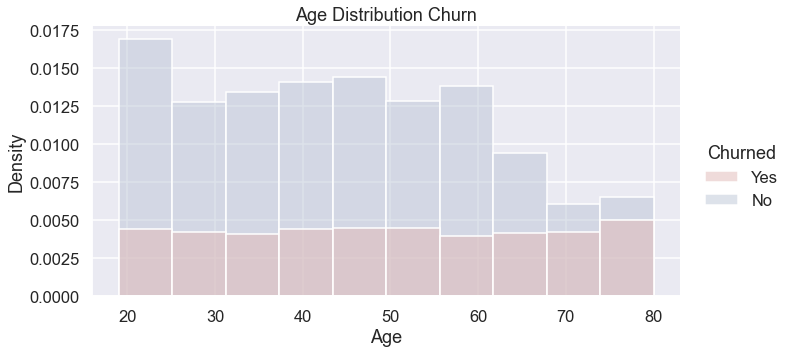

In [10]:
#Plotting a comparisonm between churned and stayed customers grouped by age.
age_dist=customer_df[["age","churn_value"]]
age_dist["Age"]=age_dist["age"]
age_dist["Churned"]=["Yes" if x == 1 else "No" for x in age_dist["churn_value"]]
sns.displot(age_dist, x="Age",bins=10, kind="hist",hue="Churned",palette="vlag_r", stat="density", aspect=2).set(title='Age Distribution Churn')
plt.show()

The majority of customers seems to be between the ages of 20 - 25, but there is a rapid decline of customers after the age of 60. Looking as well as how much each group churned, he numbers do keep consistent for each group, but a gap is much closer for the older demographic and much larger in the younger demographics.

In [11]:
#Binning age 
customer_df.age=pd.cut(x=customer_df['age'], bins=[20,30,40, 50,60,70,80], labels=["20","30","40", "50","60","70"])

In [12]:
#Cleaning missing values from "total_charge" column
hold=[]
for x in customer_df.index:
    if type(customer_df.tel_total_charges[x])== str:
        hold.append(0)
    else:
        hold.append(customer_df.tel_total_charges[x])
customer_df.tel_total_chargs=hold
#Filling NA values for churn reason
customer_df.tel_churn_reason=customer_df.tel_churn_reason.fillna("No reason given")

Now, I want to turn my attention to revenue. Since the majority of clients are on Month-to-Month, I expect that most of the payments are on the lower end. It is important for a company that has a majority of Month-to-Month customer base to improve their revenue as well as maintaining the customer turnaround.

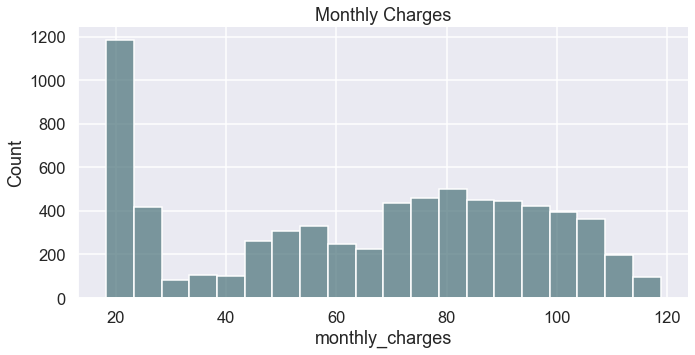

In [13]:
sns.displot(customer_df, x="monthly_charges",bins=20, kind="hist",color="#547980", aspect=2).set(title='Monthly Charges')
plt.show()

It comes with no surprise that the majority of customers have a low monthly charges. This could be due to the fact that most customers are Month-to-Month. There is a higher increase of charges from around 45 to 85 which could be the fact that we have more two year contracts. 

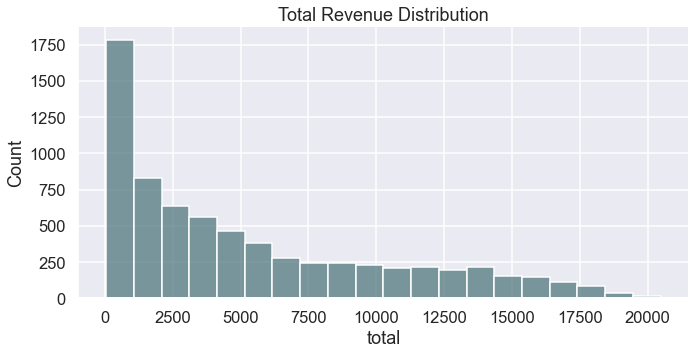

In [14]:
charge=customer_df[["total_revenue","tel_total_charges"]]
charge["total"]=charge["total_revenue"]+charge["tel_total_charges"]
sns.displot(charge, x="total",bins=20, kind="hist",color="#547980", aspect=2).set(title='Total Revenue Distribution')
plt.show()

But now compared to the total revenue the company experienced we see that mostly it concentrates around the bottom part of the graph. As stated before, this could be due to the influence the contracts have on revenue. 

Based on [Pewrsearch.org](https://www.pewresearch.org/internet/2015/04/01/chapter-one-a-portrait-of-smartphone-ownership/) analysis, some 29% of smartphone owners are on an individual plan (which includes pre-paid plans), and most of these users spend less than $100 per month on their cell phone bill. This is specially relevant since we see that the majority of monthly plans are from 20 to 25 dollars. 


Lastly I wanted to look at how much each age group spent, by using a boxplot, I intend to show how much each age group spent on the company. I combined the columns of Total Charges and Total revenue, this two columns represent Internet and Telephone Revenue. 

Text(0.5, 1.0, 'Revenue by Age')

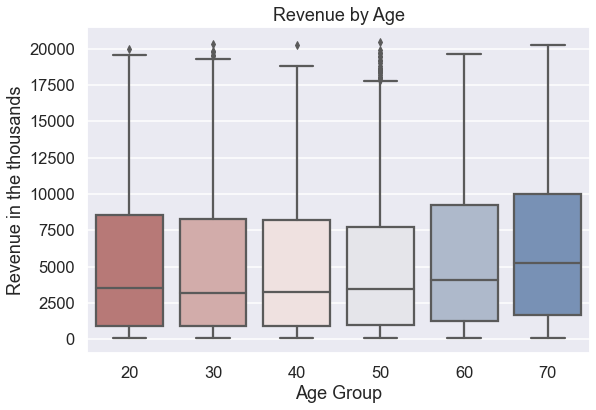

In [15]:
#Plotting how much revenue each age group generates.
fig, ax = plt.subplots(figsize=(9,6))
ax=sns.boxplot(customer_df.age,(customer_df.total_revenue+customer_df.tel_total_charges),palette="vlag_r")
ax.set_xlabel("Age Group")
ax.set_ylabel("Revenue in the thousands")
ax.set_title("Revenue by Age")


In this findings it is interesting that the majority of money came from the older demographics (70 year olds) since the previous study mentioned that younger generations (In this case the 20 year olds, which came in second) tend to spend more than the older generation.

In [16]:
# Reclassifying nan values from Churn Category.
conditions=[
    (customer_df["churn_categor"].isna())& (customer_df["churn_value"]==0),            
    (customer_df["churn_categor"].isna())& (customer_df["churn_value"]==1),
]
choises=[
    "Not Churned",
    "No Reason",

]
customer_df.churn_categor=np.select(conditions,choises,default=customer_df.churn_categor)

In [17]:
# Re categorizing the churn reason for better interpretation.
customer_df["tel_churn_reason"]=reason_cleanup("tel_churn_reason",customer_df)

After getting a sense of where the revenue of the company was, I wanted to focus on why customers left. By looking at the reason of why a customer decided to leave, we can focus efforts on improving that area of services. The following graph shows the percentage of each churn reason.

Text(0.5, 1.0, 'Reason for Churn')

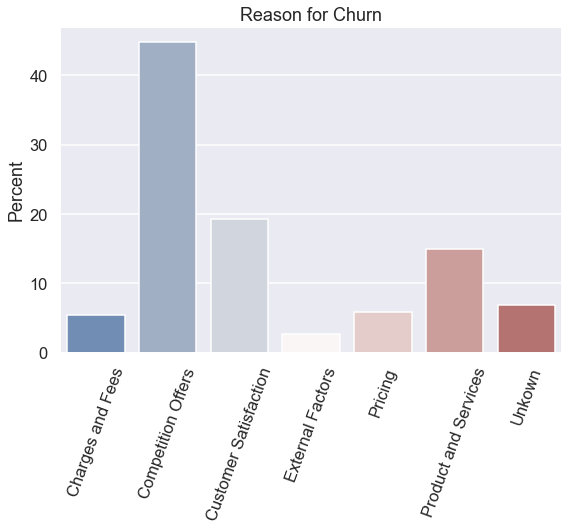

In [18]:
reason=pd.melt(customer_df[["tel_churn_reason","age"]].groupby("tel_churn_reason").count().T).drop(3,axis=0).reset_index(drop=True)
reason["value"]=percentage_col(reason,"value")
fig, ax = plt.subplots(figsize=(9,6))
ax=sns.barplot(x=reason.tel_churn_reason,y=reason.value,palette="vlag")
sns.set('talk')
ax.set_xticklabels(reason.tel_churn_reason,rotation=70)
ax.set_ylabel("Percent")
ax.set_xlabel("")
ax.set_title("Reason for Churn")

This graph is giving us a lot of information. We can see that almost 50% of customers left due to competition providing better offers, this is followed by Customer satisfaction. This can give us an idea that in our company, the main reason why customers are leaving is because our competitors are providing better pricing or deals that we are.

According to [The Database Marketing Institute](http://www.dbmarketing.com/telecom/churnreduction.html) Roughly 75 percent of the 17 to 20 million subscribers signing up with a new wireless carrier every year are coming from another wireless provider and hence are already churners. It costs hundreds of dollars to acquire a new customer in most Telecom industries. 

Following the reason of why did customers left, I wanted to look at how much customers who churned spent compared to the reason why they left. The total is calculated by summing the Total Revenue and Tel Total Charges to view the total revenue of each customer. 

Text(0.5, 1.0, 'Revenue from Churned Customers, Distribution by Reason for Leaving')

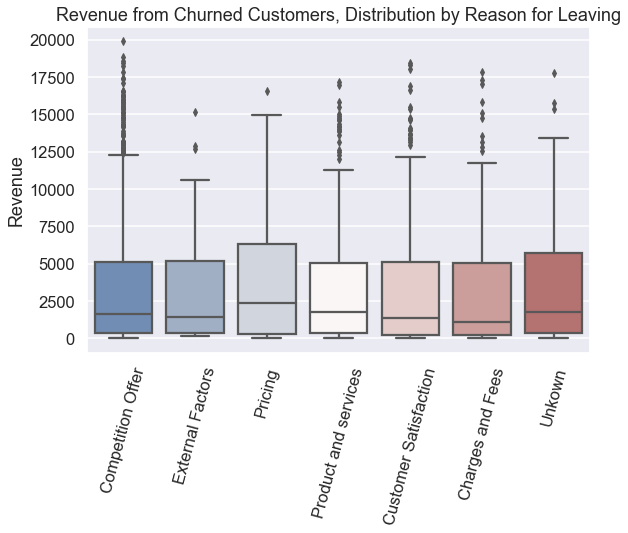

In [19]:
# Plotting the revenue that was lost from the customers that left and why they left. 
fig, ax = plt.subplots(figsize=(9,6))
reasons=customer_df[customer_df["tel_churn_reason"]!="Did Not Churn"][["tel_churn_reason","total_revenue","tel_total_charges"]]
reasons["total"]= reasons["total_revenue"]+reasons["tel_total_charges"]
ax=sns.boxplot(x=reasons.tel_churn_reason,y=reasons.total,palette="vlag")
sns.set('talk')
ax.set_xticklabels(["Competition Offer","External Factors","Pricing","Product and services","Customer Satisfaction","Charges and Fees","Unkown"],rotation=75)
ax.set_xlabel("")
ax.set_ylabel("Revenue")
ax.set_title("Revenue from Churned Customers, Distribution by Reason for Leaving")

What stands out is that customers who had issues with pricing of the services had brought the most revenue and not the ones who were offered better services from the competition. It is to be expected that customers who feel that they are being overcharged would cancel their services. What is also interesting to note is that even though competition offer is not the highest, it has the most outliers suggesting that they were also overpaying and the competition offered better prices.

In [20]:
#converting columns into binary
col_to_bin=["senior_citizen","partner","dependents","phone_service","device_protection","tech_support","paperless_billing","referred_a_friend","device_protection_plan","premium_tech_support","streaming_music","unlimited_data","under_30","tel_internet_service","tel_online_securit","tel_online_backup","tel_multiple_lines","tel_streaming_tv","tel_streaming_movies"]
for x in col_to_bin:
    to_binary(x,customer_df)

In [21]:
customer_df.drop(["tel_churn_reason","churn_categor","customer_status"],axis=1, inplace=True)

In [22]:
customer_df=pd.get_dummies(customer_df,columns=["cit","zip_code","latitude","longitude","gender","offer","internet_type","age","tel_payment_method","tel_contract"],drop_first=True)

In [23]:
customer_df=customer_df.astype("float")

# Modeling

Following the EDA I wanted to create a model that could help prevent the customer loss and revenue loss. 

All modeling processes where done in the [Modeling Notebook](EDA_&_Modeling/Modeling_Notebook.ipynb)

Using Accuracy score as the main scoring metric, Recall since we want to minimize the False Positive predictions so the company does not focuses on customers that may not churn and F1 to look at the overall model score.

In [24]:
df=pd.read_csv("EDA_&_Modeling/modeling_customer_df.csv",index_col="Unnamed: 0")

In [25]:
df

,senior_citizen,partner,dependents,tenure_months,phone_service,device_protection,tech_support,paperless_billing,monthly_charges,cltv,satisfaction_score,referred_a_friend,number_of_referrals,tenure_in_months,avg_monthly_long_distance_charges,avg_monthly_gb_download,device_protection_plan,premium_tech_support,streaming_music,unlimited_data,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,under_30,number_of_dependents,tel_internet_service,tel_online_securit,tel_online_backup,tel_multiple_lines,tel_streaming_tv,tel_total_charges,tel_streaming_movies,cit_Adelanto,cit_Anaheim,cit_Apple Valley,cit_Bakersfield,cit_Brea,cit_Cerritos,cit_Chula Vista,cit_Concord,cit_Crescent Mills,cit_El Monte,cit_Elk Grove,cit_Fremont,cit_Fresno,cit_Glendale,cit_Hayward,cit_Huntington Beach,cit_Inglewood,...,cit_San Diego,cit_San Dimas,cit_San Francisco,cit_San Jose,cit_Santa Barbara,cit_Santa Monica,cit_Santa Rosa,cit_Smith River,cit_Stockton,cit_Sun City,cit_Temecula,cit_Whittier,zip_code_90623,zip_code_91010,zip_code_91206,zip_code_91762,zip_code_93245,zip_code_93702,zip_code_93711,zip_code_94027,zip_code_94520,latitude_33.8681,latitude_34.162515,latitude_36.739385,longitude_-121.55325,longitude_-120.653519,longitude_-119.82947,longitude_-118.24902,longitude_-118.203869,longitude_-117.815532,gender_Male,offer_Offer A,offer_Offer B,offer_Offer C,offer_Offer D,offer_Offer E,internet_type_DSL,internet_type_Fiber Optic,internet_type_None,age_20,age_30,age_40,age_50,age_60,age_70,tel_payment_method_Credit Card,tel_payment_method_Mailed Check,tel_contract_One Year,tel_contract_Two Year,y
0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,53.85,3239.0,1.0,0.0,0.0,2.0,10.47,21.0,0.0,0.0,0.0,1.0,0.00,0.0,20.94,129.09,0.0,0.0,1.0,1.0,1.0,0.0,0.0,108.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,70.70,2701.0,2.0,0.0,0.0,2.0,9.12,51.0,0.0,0.0,0.0,1.0,0.00,0.0,18.24,169.89,1.0,2.0,1.0,0.0,0.0,0.0,0.0,151.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,8.0,1.0,1.0,0.0,1.0,99.65,5372.0,3.0,0.0,0.0,8.0,12.15,26.0,1.0,0.0,1.0,1.0,0.00,0.0,97.20,917.70,0.0,2.0,1.0,0.0,0.0,1.0,1.0,820.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,28.0,1.0,1.0,1.0,1.0,104.80,5003.0,3.0,0.0,0.0,28.0,4.89,47.0,1.0,1.0,1.0,1.0,0.00,0.0,136.92,3182.97,1.0,3.0,1.0,0.0,0.0,1.0,1.0,3046.05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,49.0,1.0,1.0,0.0,1.0,103.70,5340.0,1.0,0.0,0.0,49.0,44.33,11.0,1.0,0.0,1.0,1.0,0.00,0.0,2172.17,7208.47,0.0,1.0,1.0,0.0,1.0,1.0,1.0,5036.30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [26]:
#Splitting the data into X and Y
y=df["y"]
X=df.drop(["y"],axis=1)

In [27]:
# Creating Train Test Split.
X_test,X_train,y_test,y_train=train_test_split(X,y, test_size=.2, random_state=2020)

## Final Model

I want to explore Gradient Boost. Gradient boost seemed the most promising since it's scores seemed a bit erratic. I believe with a bit of tunning it could show much improvement. The tunning parameters or Gradient boosting are":
* Min Samples Split with a range of 2 to 10, I want to see if a lower or higher value could return a better score.
* Max Depth with a range of 1 to 5, by maintaining lower scores to reduce overfitting.

In previous iterations of GridSearch, the tunning parameters were
* Max Features with "Auto", "Sqrt" and "Log 2" to see witch of the exponential number of features to consider when looking for the best split.
* Loss of "Deviance" and "Exponential" "Deviance" refers to deviance (= logistic regression) for classification with probabilistic outputs. For loss "Exponential" gradient boosting recovers the AdaBoost algorithm.
* Learning Rate of range 0.1 to 5 to shrink the contribution of each tree by learning_rate.

In [28]:
#Choosing Parameter for the model.
params_gb2={
   "loss" : ['deviance', 'exponential'],
   "learning_rate" : np.arange(0.1,5,0.1),
}

In [29]:
# using vanilla Logistic Regression model and keeping the Random state for continuity and reproducibility
gb =  GradientBoostingClassifier(max_depth=4, max_features='sqrt', min_samples_split=9, random_state=40)
grid_gb2=GridSearchCV(gb, params_gb2, cv=5, scoring="accuracy", verbose=1, n_jobs=-1)

In [30]:
grid_gb2.fit(X_train,y_train)

Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:   16.0s finished


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4,
                                                  max_features='sqrt',
                                                  min_samples_split=9,
                                                  random_state=40),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
                         'loss': ['deviance', 'exponential']},
             scoring='accuracy', verbose=1)

In [31]:
print("Best Gridsearch Score: {}".format(grid_gb2.best_score_))
print("Best Parameters: {}".format(grid_gb2.best_params_))
print("Best Estimators: {}".format(grid_gb2.best_estimator_))

Best Gridsearch Score: 0.9531586784785846
Best Parameters: {'learning_rate': 1.1, 'loss': 'exponential'}
Best Estimators: GradientBoostingClassifier(learning_rate=1.1, loss='exponential', max_depth=4,
                           max_features='sqrt', min_samples_split=9,
                           random_state=40)


It seemed that Ridge was the best at keeping the relevant features for the model to perform optimally. It came as no surprise that balancing the class is the best way to have a model improve. 

In [32]:
grid_gb_pred2=grid_gb2.best_estimator_.predict(X_test)

In [33]:
scoring(grid_gb_pred2,grid_gb2,X_train,y_train,y_test,"Grid Search Gradient Boost 2", 5)

Training Accuracy: 1.0
Training Recall: 1.0
Training F1: 1.0

Grid Search Gradient Boost 2 Accuracy: 0.9565140220092296
Grid Search Gradient Boost 2 Recall: 0.9026315789473685
Grid Search Gradient Boost 2 F1: 0.918032786885246

Cross-Validation (5 times) Accuracy Scores:
Min:  0.950355   Max:  0.957447   Mean:  0.953159   Range:  0.007092


Overall this model came out with the best scores overall. With great Accuracy and F1, as well as an improved Recall, we could see this model performing great specially after looking at the CV scores since they seem to be with minimal difference in each fold. The only concerning part is that the Training scores are Overfit, this could be mitigated by some more regularization but overall after comparing the CV and the final scores it seems that this can be the final model for the company's churn algorithm. 

# Final Results

Looking at the final graph that contains all the model predictions and plotted them where we are able to see the amount of customer the model predicted right and wrong. Since we are looking to prevent customers from canceling their contracts, since we have a heavy turn around in the Month-to-Month, where we want to minimize is where the model predicted that the customer left but it actually did not. 

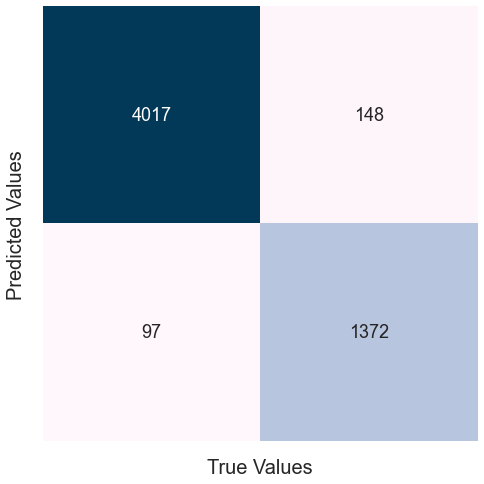

In [34]:
pred = confusion_matrix(y_test, grid_gb_pred2)
plt.figure(figsize=(8,8))

sns.heatmap(pred.T, square=True, annot=True, fmt='d',cmap="PuBu", cbar=False,
            xticklabels=['', ''], yticklabels=['', ''])
sns.set(font_scale=2)
plt.xlabel('True Values',fontsize=20)
plt.ylabel('Predicted Values',fontsize=20);


After looking at the results, we can see that the model was able to classify 95% accurately. We were able to have the least number of customers who stayed but were predicted to churn. This is something important when it comes to maintaining a customer base, by reducing the customers who were predicted to leave when they didn't we can reduce company resources in trying to maintain them. Although the numbers are not perfect it can be of great help for this company in reducing the churn rate of its customers.

Lastly, I want to explore the feature importance in each prediction. I took two random customers, one who was predicted to leave and one who was predicted to stay and viewed each feature that influenced the decision of the model.

In [35]:
col_names=names()

In [36]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   mode = 'classification',
                                                   feature_names = col_names,
                                                   categorical_features = [3], 
                                                   categorical_names = ['No',"Yes"], 
                                                   discretize_continuous = True)
                                                   
np.random.seed(42)
exp = explainer.explain_instance(X_train.values[31], grid_gb2.best_estimator_.predict_proba, num_features = 5)
exp.show_in_notebook(show_all=False) #only the features used in the explanation are displayed

exp = explainer.explain_instance(X_train.values[51], grid_gb2.best_estimator_.predict_proba, num_features = 5)
exp.show_in_notebook(show_all=False) #only the features used in the explanation are displayed

By looking at the comparison for each customer we can see that the model views the customer satisfaction score in each decision. The Satisfaction score is in a 1 to 5 scale, where 1 is poor and 5 is great, in the prediction to stay we see that the satisfaction is 4 which is high but in the prediction to leave the satisfaction score is 2 which is low.

We can also see that having a contract (1 meaning Yes and 0 meaning No) the customer who said he did have a contract was predicted to stay and the one who did was predicted to leave. 

Viewing at this graph we can see that Satisfaction Score and having a Contract tend to have higher odds on predicting the Negative or Positive Class and it could be explored further.

# Conclusions

In conclusion, in the EDA process we found that having a Month-to-Month contract greatly influenced the churn rate of the company and that the company suffers from an above average churn rate for a Telecom company. We also saw that customers who were paying more were the ones who left the company due to pricing but the customers who left due to Competitor's best offer had the most outlying charges and this was confirmed with the majority of customer's reason for leaving was due to the competition.

Viewing at coefficients showed us that customers who are in contracts are less likely to churn as well as customers who are happy enough with the company and are willing to have online security could mean that they are less likely to churn.

In the end, the company could explore in providing affordable One Year contracts for customers who are month to moth, as the study from Pewresearch.com shows, most Month-to-Month customers tend to pay less for their contracts and this is a possible avenue to explore. Since in the EDA steps we see that the competition has provided with better offers, having a diverse contract options or more flexible services could improve customer retention.

By also using this model and focus on the coefficients of the features, we could create a system that could alert if a customer has a higher chance of churn and the company can focus offers to increase retention rate.

# Further Steps

* Improving Model using:  Clustering or fine tunned GridSearch and focus on coefficients.

* Improve Features using: Feature interactions & Polynomials

* Improve EDA by: Exploring Zipcodes, Explore Month to Month Contracts, Explore in depth all Revenue related columns.